# Applying the bilinear system identification Landau-Zener 

In [1]:
from qutip import *
import matplotlib.pyplot as plt
from bi_sys_id_quantum import *

In [2]:
def get_quantum_expectation(pulse, times):
    """
    Calculate the time-series for the expectation value of a quantum observable 
    pulse - a function of two arguments
    """
    Hamiltonian = [sigmaz(), [sigmax(), pulse]]
    
    return mesolve(
        Hamiltonian, basis(2, 0), times, [], [sigmaz() + sigmax()]
    ).expect[0]

In [3]:
p = 100
dt = 0.01
F = 20.

times = dt * np.arange(500)

In [4]:
original_responses = [
    get_quantum_expectation(
        lambda t, args: F * (t < N * dt), 
        times
    ) for N in range(1, p + 1)
]

original_responses = np.array(original_responses)

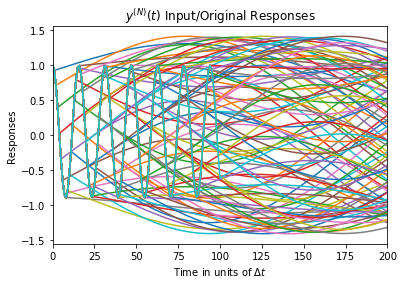

In [5]:
plt.title("$y^{(N)}(t)$ Input/Original Responses")
plt.plot(original_responses.T)
plt.xlabel("Time in units of $\Delta t$")
plt.ylabel("Responses")
plt.savefig('input.pdf')
plt.xlim(0, 200)
plt.show()

In [6]:
reconstructed = bi_sys_id_my_version(
    original_responses, 
    alpha = int(original_responses.shape[1] / 2),
    dt = dt,
    v = [F],
    #rank=4
)

In [7]:
# if isfor x in reconstructed]
reconstructed

Reconstructed(Ac=array([[ 0.01713509,  0.26668507,  0.05479256],
       [ 0.26668507, -0.15945596,  2.02263393],
       [-0.05479256, -2.02263393,  0.14232087]]), C=array([[-1.012868  ,  0.49643107, -0.58935124]]), Nc=[array([[ 0.38210683,  0.87730436,  0.93932318],
       [-2.2761524 ,  0.05068299, -0.33919272],
       [-2.32396962, -0.03505934, -0.43278972]])], x0=array([[-1.05083854],
       [ 0.03842518],
       [ 0.14157862]]))

In [8]:
reconstructed_responses = get_training_responses(reconstructed, times, p, [F])

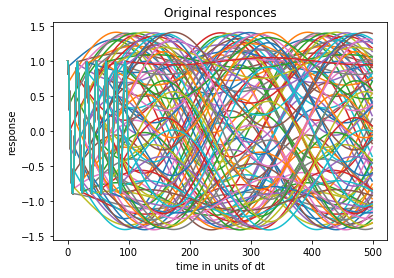

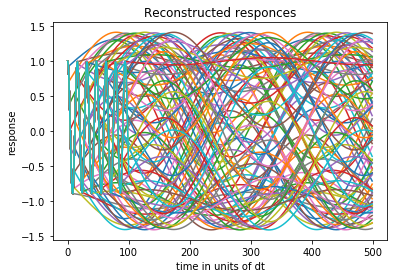

In [9]:
plt.title("Original responces")
plt.plot(original_responses.T)
plt.xlabel("time in units of dt")
plt.ylabel("response")
plt.show()

plt.title("Reconstructed responces")
plt.plot(reconstructed_responses.T)
plt.xlabel("time in units of dt")
plt.ylabel("response")
plt.show()

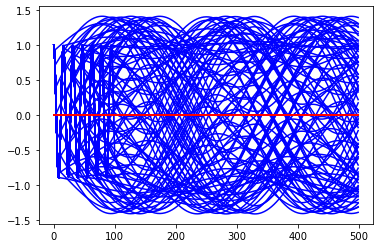

In [10]:
plt.plot(reconstructed_responses.T, 'b')
plt.plot(original_responses.T - reconstructed_responses.T.real, 'r')
#plt.ylim([-1, 1.])
plt.show()

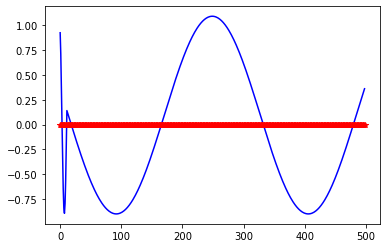

In [11]:
plt.plot(original_responses[11].T[1:], 'b')
plt.plot((original_responses - reconstructed_responses.real)[11].T[1:], '*r')
#plt.xlim([0, 7.])
plt.show()

In [12]:
np.abs(original_responses - reconstructed_responses).max()

0.00012136876342511149

## Testing the reconstructed model

In [13]:
pulse = lambda t, args=0: 10. * np.sin(70. * t) # 1e-2* np.sin(2 * (t + 0.5 * t ** 2))

In [14]:
import copy
model = copy.deepcopy(reconstructed)

In [15]:
#model.Ac[:] = 0.5 * (model.Ac - model.Ac.conj().T)
#model.Nc[0][:] = 0.5 * (model.Nc[0] - model.Nc[0].conj().T)

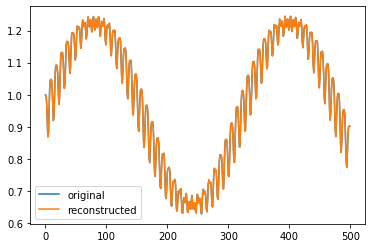

In [16]:
plt.plot(get_quantum_expectation(pulse, times), label='original')
plt.plot(get_response(model, pulse, times), label='reconstructed')

#plt.ylim([-10, 10])
#plt.xlim([0, 200])

plt.legend()

plt.show()

In [17]:
np.linalg.eig(model.Ac)

(array([-3.54938293e-10+0.j        ,  7.54068336e-10+1.99998545j,
         7.54068336e-10-1.99998545j]),
 array([[ 0.99039495+0.j        , -0.09335888-0.02554411j,
         -0.09335888+0.02554411j],
        [-0.03621885+0.j        ,  0.05228402-0.69849696j,
          0.05228402+0.69849696j],
        [-0.1334393 +0.j        ,  0.70710678+0.j        ,
          0.70710678-0.j        ]]))

In [18]:
(
    tensor(qeye(2), sigmaz()) - tensor(sigmaz(), qeye(2))
).eigenenergies()

array([-2.,  0.,  0.,  2.])

In [19]:
np.linalg.eig(model.Nc[0])

(array([ 1.61686167e-07+2.0000011j,  1.61686167e-07-2.0000011j,
        -2.18239816e-07+0.j       ]),
 array([[-0.12143933-0.51931556j, -0.12143933+0.51931556j,
         -0.1204096 +0.j        ],
        [ 0.58973654-0.0506607j ,  0.58973654+0.0506607j ,
         -0.70059857+0.j        ],
        [ 0.60432453+0.j        ,  0.60432453-0.j        ,
          0.70332295+0.j        ]]))

In [20]:
reconstructed.Ac

array([[ 0.01713509,  0.26668507,  0.05479256],
       [ 0.26668507, -0.15945596,  2.02263393],
       [-0.05479256, -2.02263393,  0.14232087]])

In [21]:
"""
    l = 20 - 4

    transpose = np.array(
        [[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]
    )
        
    Phi = np.block([
        [0.5 * (np.eye(4) + transpose), np.zeros((4, l))],
        [np.zeros((l, 4)), np.eye(l)],
    ])

    Phi[1, -1] = Phi[2, -2] = Phi[-1, 1] = Phi[-2, 2] = 0.5
"""

'\n    l = 20 - 4\n\n    transpose = np.array(\n        [[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]\n    )\n        \n    Phi = np.block([\n        [0.5 * (np.eye(4) + transpose), np.zeros((4, l))],\n        [np.zeros((l, 4)), np.eye(l)],\n    ])\n\n    Phi[1, -1] = Phi[2, -2] = Phi[-1, 1] = Phi[-2, 2] = 0.5\n'